## Importing all the libraries

In [8]:
import numpy as np
import pandas as pd
from random import choice
from time import time
from tqdm import tqdm

from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.poincare_ball import PoincareBall

import graphicle as gcl
#from graphicle import duplicates
from heparchy.read.hdf import HdfReader

from embedding import HyperEmbedding
from dataHandler import ParticleDataset

import logging
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
plt.style.use('dark_background')

INFO: Using numpy backend


## Load data

In [2]:
event_idx = 0
dataset = ParticleDataset('data/hz_train.hdf5','signal')
data = dataset.__getitem__(event_idx)

with HdfReader('data/hz_train.hdf5') as hep_file:
    process = hep_file.read_process(name='signal')
    event = process.read_event(event_idx)
    graph = gcl.Graphicle.from_numpy(
        edges = event.edges,
        pmu = event.pmu,
        pdg = event.pdg,
        final = event.mask('final'),
    )
    hyper_coords = event.get_custom('hyper_coords')
    graph.adj = gcl.transform.particle_as_node(graph.adj)

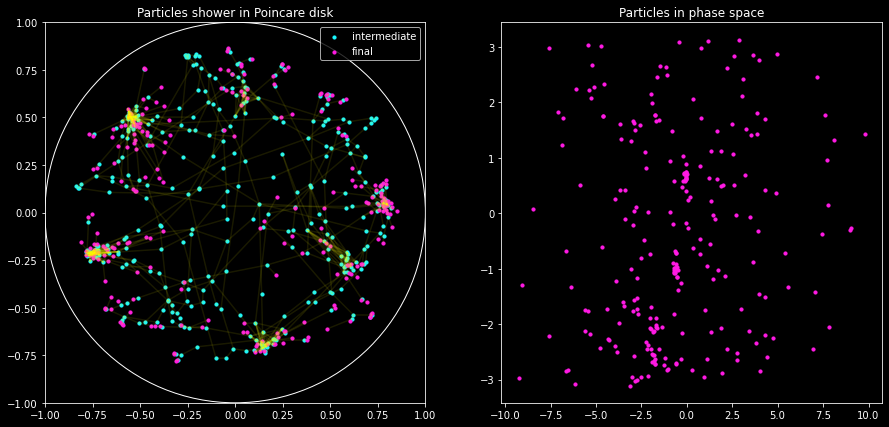

In [3]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax = ax.flatten()
#degrees = hyper.edge_pivot.out.apply(lambda x: len(x)*10).values
ax[0].scatter(hyper_coords[~graph.final.data,0],
    hyper_coords[~graph.final.data,1],
    #10*np.log(np.sqrt(degrees[~graph.final.data])),
    10,
    alpha=1,color='#1AF8FF',label='intermediate')

ax[0].scatter(hyper_coords[graph.final.data,0],
    hyper_coords[graph.final.data,1],
    #10*np.log(np.sqrt(degrees[graph.final.data]**2)),
    10,
    alpha=1,color='#FF1AE3',label='final')

for edge in graph.edges:
    start = np.where(graph.nodes == edge[0])[0][0]
    end = np.where(graph.nodes == edge[1])[0][0]
    x0,y0 = hyper_coords[start]
    x1,y1 = hyper_coords[end]
    ax[0].plot([x0,x1],[y0,y1],alpha=0.1,color='yellow')

disk = Circle((0,0),1,color='white',fill=False)
ax[0].add_patch(disk)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)

ax[0].set_title('Particles shower in Poincare disk')
ax[0].legend()


ax[1].scatter(graph.pmu.eta[graph.final.data],graph.pmu.phi[graph.final.data],10,alpha=1,color='#FF1AE3')
ax[1].set_title('Particles in phase space')


plt.show()

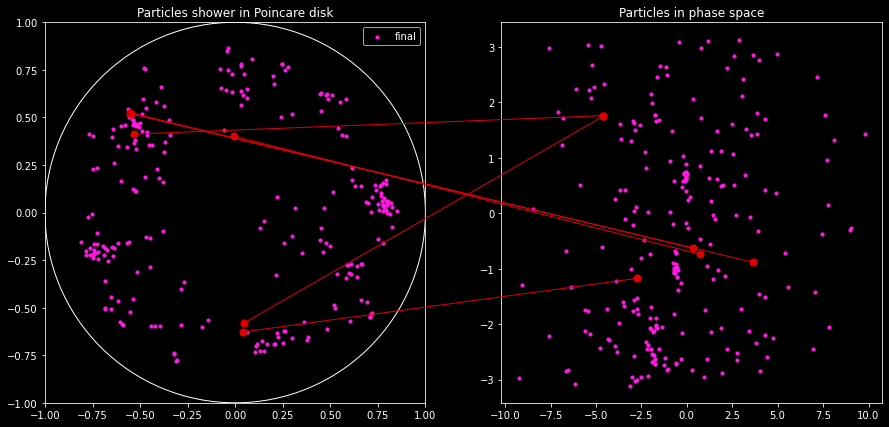

In [4]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax = ax.flatten()

ax[0].scatter(hyper_coords[graph.final.data,0],
    hyper_coords[graph.final.data,1],
    #10*np.log(np.sqrt(degrees[graph.final.data]**2)),
    10,
    alpha=1,color='#FF1AE3',label='final')


disk = Circle((0,0),1,color='white',fill=False)
ax[0].add_patch(disk)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)

ax[0].set_title('Particles shower in Poincare disk')
ax[0].legend()


ax[1].scatter(graph.pmu.eta[graph.final.data],graph.pmu.phi[graph.final.data],10,alpha=1,color='#FF1AE3')
ax[1].set_title('Particles in phase space')

idxs = [9,10,125,30,101,27]
hyper = hyper_coords[graph.final.data]
phase = np.transpose([graph.pmu.eta[graph.final.data],graph.pmu.phi[graph.final.data]])
for idx00 in idxs:
    xy_left = hyper[idx00]
    xy_right = phase[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF0101')
    fig.add_artist(con)

plt.show()

## Quantitative search

In [91]:
from scipy.spatial import distance
from manifold import PoincareManifold
import torch as th
poincare = PoincareManifold()

def distance_CA(point_a,point_b):
    R = 0.8
    if len(point_a.shape) < 2:
        point_a = np.expand_dims(point_a, axis=0)
    if len(point_b.shape) < 2:
        point_b = np.expand_dims(point_b, axis=0)
        
    raw = point_a[:,1] - point_b[:,1]
    PHI = np.min((raw%(2*np.pi), np.abs(-raw%(2*np.pi))), axis=0)
    ETA = point_a[:,0] - point_b[:,0]
    distance = (ETA**2 + PHI**2) / R **2.
    return distance

def distance_antikt(point_a,point_b,pt_0,pt_1,power=-2):
    R = 0.8
    if len(point_a.shape) < 2:
        point_a = np.expand_dims(point_a, axis=0)
    if len(point_b.shape) < 2:
        point_b = np.expand_dims(point_b, axis=0)
    if len(pt_0.shape) < 2:
        pt_0 = np.expand_dims(pt_0, axis=0)
    if len(pt_1.shape) < 2:
        pt_1 = np.expand_dims(pt_1, axis=0)
        
    raw = point_a[:,1] - point_b[:,1]
    PHI = np.min((raw%(2*np.pi), np.abs(-raw%(2*np.pi))), axis=0)
    ETA = point_a[:,0] - point_b[:,0]
    PT = np.minimum(pt_0 ** (power),pt_1 ** (power))
    distance = PT * (ETA**2 + PHI**2) / R**2.
    return distance

#cousing_degree=1 mean the first neighbor, 2 is the second closest neighbors
def closest_node_CA(node, nodes,cousin_degree=1):
    closest_index = np.argsort(distance_CA(node, nodes))[cousin_degree]
    return closest_index

def closest_node_hyper(node, nodes,cousin_degree=1):
    closest_index = np.argsort(poincare.distance(th.Tensor(node),th.Tensor(nodes)))[cousin_degree]
    return closest_index

def closest_node_antikt(node,nodes,pt_0,pts,power=-2.,cousin_degree=1):
    closest_index = np.argsort(distance_antikt(node,nodes,pt_0,pts))[0][cousin_degree]
    return closest_index

def closest_node_kt(node,nodes,pt_0,pts,power=2.,cousin_degree=1):
    closest_index = np.argsort(distance_antikt(node,nodes,pt_0,pts,power))[0][cousin_degree]
    return closest_index

In [92]:
def compute_neighbors(phase,hyper,pt,cousin_degree=1):
    CA_distance = []
    hyper_distance = []
    antikt_distance = []
    kt_distance = []
    for idx in range(len(hyper)):
        CA_idx = closest_node_CA(phase[idx],phase,cousin_degree)
        CA_distance.append(CA_idx)
    
        hyper_idx = closest_node_hyper(hyper[idx],hyper,cousin_degree)
        hyper_distance.append(hyper_idx)
        
        antikt_idx = closest_node_antikt(phase[idx],phase,np.array([pt[idx]]),pt,cousin_degree)
        antikt_distance.append(antikt_idx)
        
        kt_idx = closest_node_kt(phase[idx],phase,np.array([pt[idx]]),pt,cousin_degree)
        kt_distance.append(kt_idx)
        
    return np.array(CA_distance),np.array(hyper_distance),np.array(antikt_distance),np.array(kt_distance)

In [93]:
def compute_rate(phase,hyper,CA_distance,hyper_distance,antikt_distance,kt_distance):
    final_nodes = graph.nodes[graph.final.data]
    CA_neighbors = []
    hyper_neighbors = []
    antikt_neighbors = []
    kt_neighbors = []
    for i in range(len(hyper)):
        #for every final state look at its parents
        idx = np.where(graph.edges['out'] == final_nodes[i])[0]
        in_particles = graph.edges['in'][idx]

        #find the right indices of the parents 
        in_particles_idx = np.array([
            np.where(graph.edges['in'] == j)[0] for j in in_particles])
        in_particles_idx = np.array([item for sublist in in_particles_idx for item in sublist])

        #find all the children of those parents
        out_particles = graph.edges['out'][in_particles_idx]

        final_CA = final_nodes[CA_distance[i]]
        final_hyper = final_nodes[hyper_distance[i]]
        final_antikt = final_nodes[antikt_distance[i]]
        final_kt = final_nodes[kt_distance[i]]

        #check if the computed neighbors correspond to direct cousins
        CA_neighbors.append(final_CA in out_particles)
        hyper_neighbors.append(final_hyper in out_particles)
        antikt_neighbors.append(final_antikt in out_particles)
        kt_neighbors.append(final_kt in out_particles)

    p_rate = np.sum(CA_neighbors)/len(hyper)
    h_rate = np.sum(hyper_neighbors)/len(hyper)
    a_rate = np.sum(antikt_neighbors)/len(hyper)
    k_rate = np.sum(kt_neighbors)/len(hyper)
    return p_rate,h_rate,a_rate,k_rate

In [94]:
CA_rate = []
hyper_rate = []
antikt_rate = []
kt_rate = []
for event_idx in tqdm(range(len(process))):
    with HdfReader('data/hz_test.hdf5') as hep_file:
        process = hep_file.read_process(name='signal')
        event = process.read_event(event_idx)
        graph = gcl.Graphicle.from_numpy(
            edges = event.edges,
            pmu = event.pmu,
            pdg = event.pdg,
            final = event.mask('final'),
        )
        hyper_coords = event.get_custom('hyper_coords')
        graph.adj = gcl.transform.particle_as_node(graph.adj)
    
    hyper = hyper_coords[graph.final.data]
    phase = np.transpose([graph.pmu.eta[graph.final.data],graph.pmu.phi[graph.final.data]])
    pt = graph.pmu.pt[graph.final.data]
    
    CA_distance, hyper_distance, antikt_distance, kt_distance = compute_neighbors(phase,hyper,pt)
    p_rate, h_rate, a_rate, k_rate = compute_rate(phase,hyper,CA_distance,hyper_distance,\
                                                  antikt_distance,kt_distance)
    CA_rate.append(p_rate)
    hyper_rate.append(h_rate)
    antikt_rate.append(a_rate)
    kt_rate.append(k_rate)

100%|████████████████████████████████████████████████████████| 499/499 [03:53<00:00,  2.14it/s]


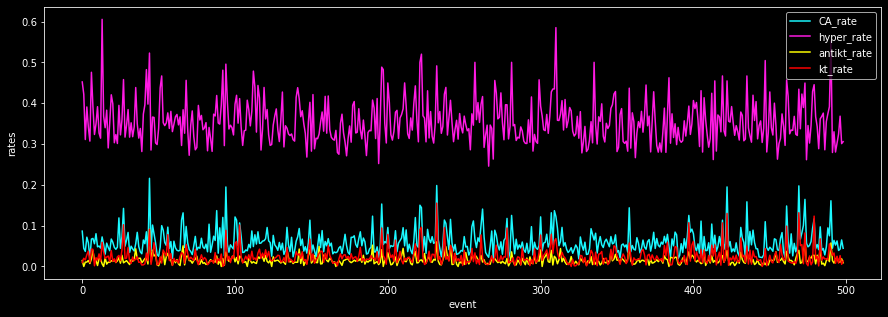

In [96]:
fig,ax = plt.subplots(figsize=(15,5))

ax.plot(range(len(process)), phase_rate, c='#1AF8FF', label='CA_rate')
ax.plot(range(len(process)), hyper_rate, c='#FF1AE3', label='hyper_rate')
ax.plot(range(len(process)), antikt_rate, c='yellow', label='antikt_rate')
ax.plot(range(len(process)), kt_rate, c='red', label='kt_rate')

ax.set_xlabel('event')
ax.set_ylabel('rates')
ax.legend()

In [98]:
CA_rate = []
hyper_rate = []
antikt_rate = []
kt_rate = []
for event_idx in tqdm(range(len(process))):
    with HdfReader('data/gz_test.hdf5') as hep_file:
        process = hep_file.read_process(name='background')
        event = process.read_event(event_idx)
        graph = gcl.Graphicle.from_numpy(
            edges = event.edges,
            pmu = event.pmu,
            pdg = event.pdg,
            final = event.mask('final'),
        )
        hyper_coords = event.get_custom('hyper_coords')
        graph.adj = gcl.transform.particle_as_node(graph.adj)
    
    hyper = hyper_coords[graph.final.data]
    phase = np.transpose([graph.pmu.eta[graph.final.data],graph.pmu.phi[graph.final.data]])
    pt = graph.pmu.pt[graph.final.data]
    
    CA_distance, hyper_distance, antikt_distance, kt_distance = compute_neighbors(phase,hyper,pt)
    p_rate, h_rate, a_rate, k_rate = compute_rate(phase,hyper,CA_distance,hyper_distance,\
                                                  antikt_distance,kt_distance)
    CA_rate.append(p_rate)
    hyper_rate.append(h_rate)
    antikt_rate.append(a_rate)
    kt_rate.append(k_rate)

100%|████████████████████████████████████████████████████████| 499/499 [03:40<00:00,  2.27it/s]


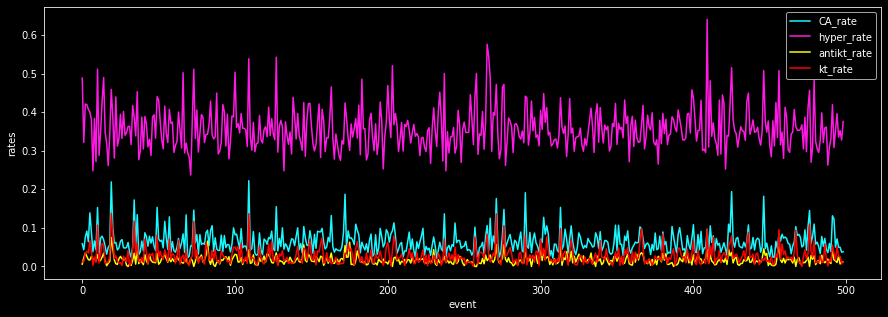

In [100]:
fig,ax = plt.subplots(figsize=(15,5))

ax.plot(range(len(process)), CA_rate, c='#1AF8FF', label='CA_rate')
ax.plot(range(len(process)), hyper_rate, c='#FF1AE3', label='hyper_rate')
ax.plot(range(len(process)), antikt_rate, c='yellow', label='antikt_rate')
ax.plot(range(len(process)), kt_rate, c='red', label='kt_rate')

ax.set_xlabel('event')
ax.set_ylabel('rates')
ax.legend()

## Checking all data is good

In [8]:
from tqdm import tqdm
event_idx = 0
dataset = ParticleDataset('data/gz_train.hdf5','background')
data = dataset.__getitem__(event_idx)

mean = []
with HdfReader('data/gz_train.hdf5') as hep_file:
    process = hep_file.read_process(name='background')
    for event_idx in tqdm(range(len(process))):
        event = process.read_event(event_idx)
        graph = gcl.Graphicle.from_numpy(
            edges = event.edges,
            pmu = event.pmu,
            pdg = event.pdg,
            final = event.mask('final'),
        )
        #hyper_coords = event.get_custom('hyper_coords')
        graph.adj = gcl.transform.particle_as_node(graph.adj)
        hyper_coords = event.get_custom('hyper_coords')
        mean.append(np.mean(hyper_coords))
        
print(f'number of rotten data: {sum(np.isnan(mean))}')

100%|███████████████████████████████████| 4999/4999 [07:50<00:00, 10.63it/s]
